In [1]:
import os, math
import pandas as pd
from collections import defaultdict
import numpy as np
from scipy import stats
from Bio import SeqIO
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
month="02"
coverage_threshold = 0.40

subtype_year2result = dict()
for subtype in ("h3n2", "h1n1"):
    year2result = dict()
    for year in range(2012, 2022):
        if year == 2021 or year == 2020 or year == 2022:
            continue
        vaccine_scores_path = "../../runs/pipeline/%d-%s/a_%s/vaccine_set=who___virus_set=%d-%s-%d-%s/vaccine_scores" % (year, month, subtype, year-3, month, year, month)
        if not os.path.exists(vaccine_scores_path):
            continue
        for file in os.listdir(vaccine_scores_path):
            if file == "prob=weight_loss_by_count_lightning_logs_version_0___hi=max_steps_150k":
                if os.path.exists(os.path.join(vaccine_scores_path, file, "vaccine_score_and_gt.csv")):
                    our_model = (pd.read_csv(os.path.join(vaccine_scores_path, file, "vaccine_score_and_gt.csv")))
                    year2result[year] = our_model

    subtype_year2result[subtype] = year2result

In [3]:
subtype_time2vaccine_strains = dict()
subtype_time2ve = dict()
for subtype in ("h3n2", "h1n1"):
    ve_path = "../../data/vaccine_effectiveness/ve_%s.csv" % subtype
    ve = pd.read_csv(ve_path)
    print(ve)
    ve["time_bin"] = [int(year.split("-")[0]) - 2018 + 30 for year in ve["Year"]]
    ve["vaccine effectiveness"] = [x if isinstance(x, float) else float(x[:-1]) for x in ve["VE"].to_numpy()]
    ve["subtype"] = [subtype] * len(ve)

    time2vaccine_strains = dict()
    time2ve = dict()

    for strains, year, eff in zip(ve["Strain"], ve["Year"], ve["vaccine effectiveness"]):
        year = int(year.split("-")[0]) # 2018
        time2vaccine_strains[year] = strains.split("|")
        time2ve[year] = eff
    subtype_time2vaccine_strains[subtype] = time2vaccine_strains
    subtype_time2ve[subtype] = time2ve

         Year   VE    95% CI                                     Strain
0   2011-2012  39%   (23 52)                            A/Perth/16/2009
1   2012-2013  39%   (29 47)                        A/Victoria/361/2011
2   2013-2014  NaN       NaN                            A/Texas/50/2012
3   2014-2015   6%   (-5 17)                            A/Texas/50/2012
4   2015-2016  NaN       NaN                 A/Switzerland/9715293/2013
5   2016-2017  33%   (23 41)                      A/Hong Kong/4801/2014
6   2017-2018  22%   (12 31)                      A/Hong Kong/4801/2014
7   2018-2019   9%   (-4 20)            A/Singapore/INFIMH-16-0019/2016
8   2019-2020  NaN       NaN                           A/Kansas/14/2017
9   2020-2021  NaN       NaN  A/Hong Kong/2671/2019|A/Hong Kong/45/2019
10  2021-2022  36%   (21 48)                   A/Cambodia/e0826360/2020
11  2022-2023  NaN       NaN            A/Darwin/9/2021|A/Darwin/6/2021
12  2023-2024  30%       NaN            A/Darwin/9/2021|A/Darwin

In [4]:

ref_vaccine_scores = []
ref_ve = []
ref_source = []
ref_subtype = []
year_array = []

for subtype in ("h3n2", "h1n1"):
    
    year2result = subtype_year2result[subtype]
    time2vaccine_strains = subtype_time2vaccine_strains[subtype]
    time2ve = subtype_time2ve[subtype]

    for year in time2vaccine_strains:
        if year not in year2result:
            continue
        vaccine_strains = time2vaccine_strains[year]
        effectiveness = time2ve[year]
        if isinstance(effectiveness, float) and not np.isnan(effectiveness):
            ref_vaccine_score_pred = []
            ref_vaccine_score_gt = []
            for gt_score, score, name, coverage in zip(year2result[year]["gt_score_seq"], year2result[year]["score"], year2result[year]["strain_name"], year2result[year]["coverage_seq"]):
                if coverage < coverage_threshold:
                    continue
                if not isinstance(name, str):
                    continue
                for vaccine_strain in vaccine_strains:
                    if vaccine_strain.replace(" ", "_") in name:
                        ref_vaccine_score_pred.append(score)
                        ref_vaccine_score_gt.append(gt_score)
                        break

            if len(ref_vaccine_score_pred) > 0:
                ref_vaccine_score = [x  for x in ref_vaccine_score_pred if not np.isnan(x)]
                if len(ref_vaccine_score) > 0:
                    ref_vaccine_scores.append(np.median(ref_vaccine_score_pred))
                    ref_ve.append(effectiveness)
                    ref_source.append("Prediction")
                    ref_subtype.append(subtype)
                    year_array.append(year)

                ref_vaccine_score_gt = [x  for x in ref_vaccine_score_gt if not np.isnan(x)]
                if len(ref_vaccine_score_gt) > 0:
                    ref_vaccine_scores.append(np.median(ref_vaccine_score_gt))
                    ref_ve.append(effectiveness)
                    ref_source.append("Ground truth")
                    ref_subtype.append(subtype)
                    year_array.append(year)


GT, Spearman: 0.9757575757575757 1.4675461874042197e-06
GT, Pearson: 0.8951857638336101 0.0004644735649437891
Predict, Spearman: 0.8909090909090909 0.0005421442248338665
Predict, Pearson: 0.861124641795302 0.001371526155052896


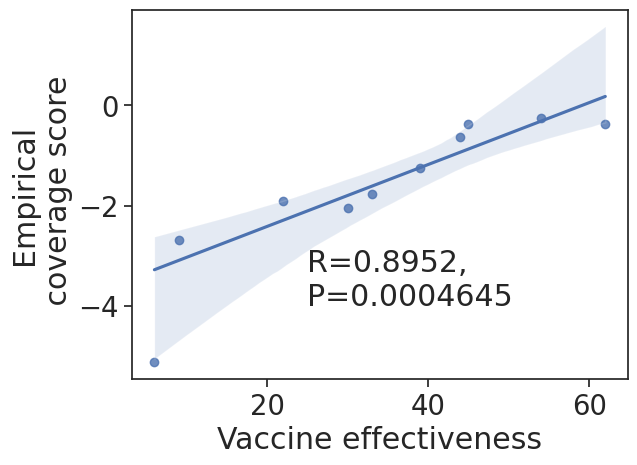

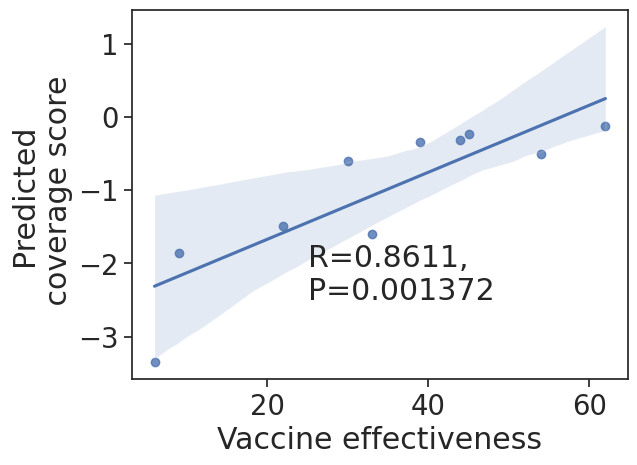

In [5]:
ref_vaccine_scores = np.asarray(ref_vaccine_scores)

d = {'vaccine effectiveness': ref_ve, 
     'escapability score': - ref_vaccine_scores, 
     'subtype': ["A/%s" % x.upper() for x in ref_subtype], '': ref_source, "year": year_array}
res = pd.DataFrame(data=d)

sns.set(font_scale=1.8, style="ticks")

gt_spearman_rank, gt_pvalue = stats.spearmanr(res[res[""] == "Ground truth"]["escapability score"], res[res[""] == "Ground truth"]["vaccine effectiveness"])
gt_pearsonr, gt_pvalue_pearson = stats.pearsonr(res[res[""] == "Ground truth"]["escapability score"], res[res[""] == "Ground truth"]["vaccine effectiveness"])

print("GT, Spearman:", gt_spearman_rank, gt_pvalue)
print("GT, Pearson:", gt_pearsonr, gt_pvalue_pearson)

pred_spearman_rank, pred_pvalue = stats.spearmanr(res[res[""] == "Prediction"]["escapability score"], res[res[""] == "Prediction"]["vaccine effectiveness"])
pred_pearsonr, pred_pvalue_pearson = stats.pearsonr(res[res[""] == "Prediction"]["escapability score"], res[res[""] == "Prediction"]["vaccine effectiveness"])

print("Predict, Spearman:", pred_spearman_rank, pred_pvalue)
print("Predict, Pearson:", pred_pearsonr, pred_pvalue_pearson)

# Ground-truth score & VE
ax = sns.regplot(y = "escapability score", x = "vaccine effectiveness",# , "x"
           data = res[res[""] == "Ground truth"], robust=True, ci=95) # ci = 95) # , ci=95
ax.text(25, -4.0, "R=%.4lf, \nP=%.4g" % (gt_pearsonr, gt_pvalue_pearson))
ax.set_ylabel("Empirical\n coverage score")
ax.set_xlabel("Vaccine effectiveness")

gt_fitline_ys = ax.get_lines()[0].get_ydata()
gt_fitline_xs = ax.get_lines()[0].get_xdata()

# plt.savefig("figs/ve_%s_gt.pdf" % subtype, format='pdf', bbox_inches='tight')
plt.show()

# Predicted scores & VE
ax = sns.regplot(y = "escapability score", x = "vaccine effectiveness",# , "x"
           data = res[res[""] == "Prediction"], robust=True, ci=95) # ci = 95) # , ci=95
ax.text(25, -2.5, "R=%.4lf, \nP=%.4g" % (pred_pearsonr, pred_pvalue_pearson))

ax.set_ylabel("Predicted\n coverage score")
ax.set_xlabel("Vaccine effectiveness")

pred_fitline_ys = ax.get_lines()[0].get_ydata()
pred_fitline_xs = ax.get_lines()[0].get_xdata()

# plt.savefig("figs/ve_%s_predicted.pdf" % subtype, format='pdf', bbox_inches='tight')
plt.show()

In [6]:
res[""] = ["Empirical" if x == "Ground truth" else x for x in res[""] ]
res[""] = ["Predict" if x == "Prediction" else x for x in res[""] ]
# res

0.06182046426579869
0.04574828642825973


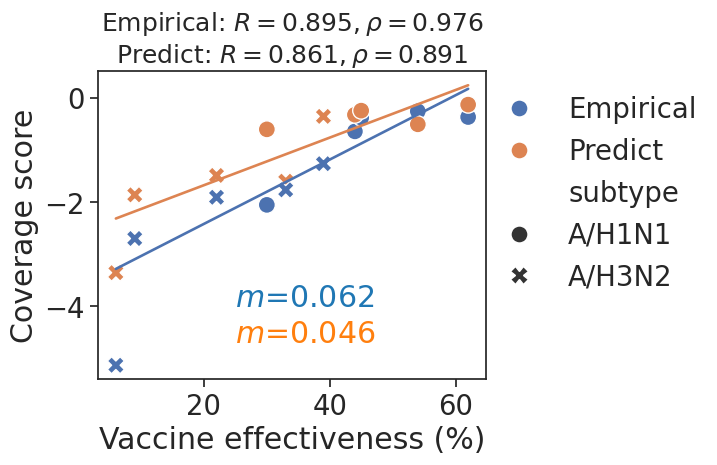

In [7]:
# combine
res = res.sort_values(by=[''], ascending=True)
res = res.sort_values(by=['subtype'], ascending=True)

# fig, ax = plt.subplots(figsize=(4.5, 4))
fig, ax = plt.subplots(figsize=(5, 4))

ax = sns.scatterplot(y = "escapability score", x = "vaccine effectiveness",# , "x"
           data = res, hue="", style="subtype", s=150, ax=ax) # ci = 95) # , ci=95

ax = sns.lineplot(y = gt_fitline_ys, x = gt_fitline_xs,linewidth=1.9) # ci = 95) # , ci=95
ax = sns.lineplot(y = pred_fitline_ys, x = pred_fitline_xs,linewidth=1.9) # ci = 95) # , ci=95

print(((gt_fitline_ys[1:] - gt_fitline_ys[:-1]) / (gt_fitline_xs[1:] - gt_fitline_xs[:-1]))[0])
print(((pred_fitline_ys[1:] - pred_fitline_ys[:-1]) / (pred_fitline_xs[1:] - pred_fitline_xs[:-1]))[0])

slope_gt = ((gt_fitline_ys[1:] - gt_fitline_ys[:-1]) / (gt_fitline_xs[1:] - gt_fitline_xs[:-1]))[0]
slope_pred = ((pred_fitline_ys[1:] - pred_fitline_ys[:-1]) / (pred_fitline_xs[1:] - pred_fitline_xs[:-1]))[0]
ax.text(25,-4.7, "$m$=%.3lf" % (slope_pred), color="#ff7f0e")
ax.text(25,-4.0, "$m$=%.3lf" % (slope_gt), color="#1f77b4")

ax.legend(frameon=False)

legend = ax.get_legend()

ax.set_title(f"Empirical: $R=%.3lf,\\rho=%.3lf$\nPredict: $R=%.3lf,\\rho=%.3lf$" % (gt_pearsonr, gt_spearman_rank, pred_pearsonr, pred_spearman_rank), fontsize=18)

ax.set_ylabel("Coverage score")
ax.set_xlabel("Vaccine effectiveness (%)")

sns.move_legend(ax, "upper left", bbox_to_anchor=(0.95, 1))

plt.savefig("figs/ve_overall_new.pdf", format='pdf', bbox_inches='tight', dpi=600)
plt.show()

In [8]:
res_h3n2 = res[res["subtype"] == "A/H3N2"]
res_h1n1 = res[res["subtype"] == "A/H1N1"]

Empirical, Spearman: 0.9999999999999999 1.4042654220543672e-24
Empirical, Pearson: 0.8338128451107456 0.07926771661987518
Pred, Spearman: 0.8999999999999998 0.03738607346849874
Pred, Pearson: 0.8454352934420716 0.07123034979655708


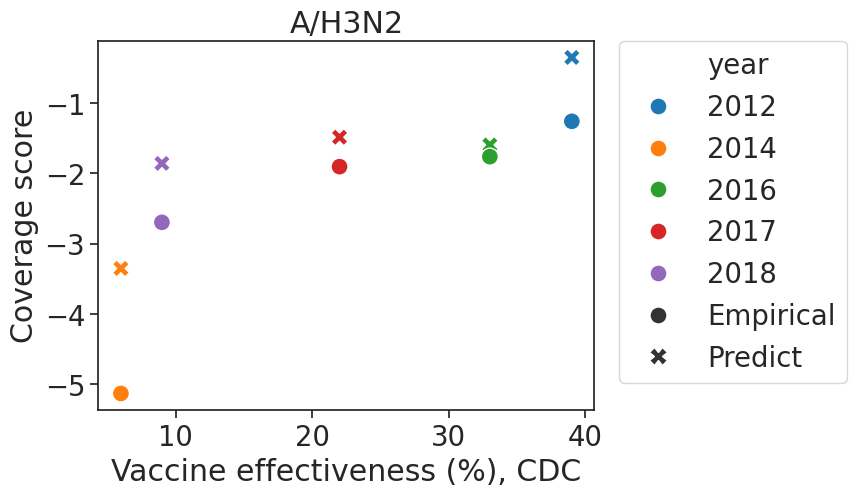

In [9]:
res_h3n2_empirical = res_h3n2[res_h3n2[""] == "Empirical"]
res_h3n2_predict = res_h3n2[res_h3n2[""] == "Predict"]

gt_spearman_rank, gt_pvalue = stats.spearmanr(res_h3n2_empirical["escapability score"], res_h3n2_empirical["vaccine effectiveness"])
gt_pearsonr, gt_pvalue_pearson = stats.pearsonr(res_h3n2_empirical["escapability score"], res_h3n2_empirical["vaccine effectiveness"])

print("Empirical, Spearman:", gt_spearman_rank, gt_pvalue)
print("Empirical, Pearson:", gt_pearsonr, gt_pvalue_pearson)

pred_spearman_rank, pred_pvalue = stats.spearmanr(res_h3n2_predict["escapability score"], res_h3n2_predict["vaccine effectiveness"])
pred_pearsonr, pred_pvalue_pearson = stats.pearsonr(res_h3n2_predict["escapability score"], res_h3n2_predict["vaccine effectiveness"])

print("Pred, Spearman:", pred_spearman_rank, pred_pvalue)
print("Pred, Pearson:", pred_pearsonr, pred_pvalue_pearson)

ax = sns.scatterplot(y = "escapability score", x = "vaccine effectiveness",# , "x"
           data = res_h3n2, style="", s=150, hue="year", palette="tab10") # ci = 95) # , ci=95
ax.set_title("A/H3N2")
ax.set_ylabel("Coverage score")
ax.set_xlabel("Vaccine effectiveness (%), CDC")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)


GT, Spearman: 0.8999999999999998 0.03738607346849874
GT, Pearson: 0.8437743771769642 0.07236256158157277
Pred, Spearman: 0.7 0.1881204043741873
Pred, Pearson: 0.6725296314928794 0.21355766267564238


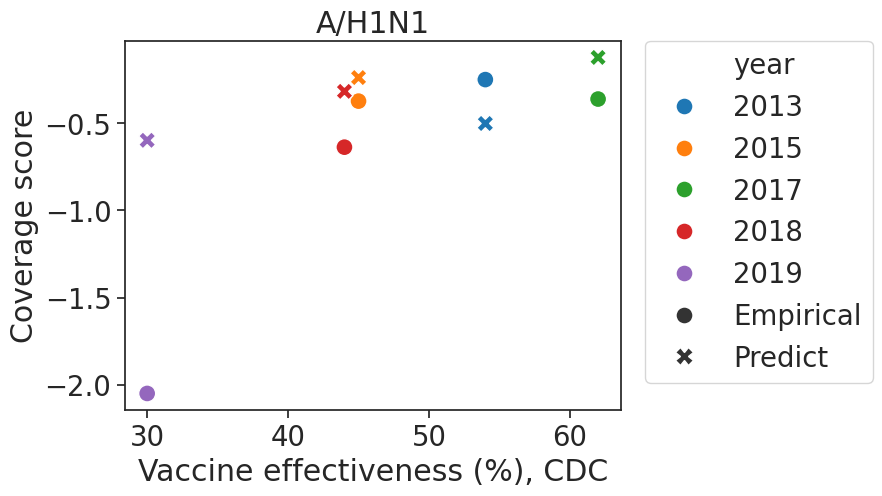

In [10]:
gt_spearman_rank, gt_pvalue = stats.spearmanr(res_h1n1[res_h1n1[""] == "Empirical"]["escapability score"], res_h1n1[res_h1n1[""] == "Empirical"]["vaccine effectiveness"])
gt_pearsonr, gt_pvalue_pearson = stats.pearsonr(res_h1n1[res_h1n1[""] == "Empirical"]["escapability score"], res_h1n1[res_h1n1[""] == "Empirical"]["vaccine effectiveness"])
print("GT, Spearman:", gt_spearman_rank, gt_pvalue)
print("GT, Pearson:", gt_pearsonr, gt_pvalue_pearson)
pred_spearman_rank, pred_pvalue = stats.spearmanr(res_h1n1[res_h1n1[""] == "Predict"]["escapability score"], res_h1n1[res_h1n1[""] == "Predict"]["vaccine effectiveness"])
pred_pearsonr, pred_pvalue_pearson = stats.pearsonr(res_h1n1[res_h1n1[""] == "Predict"]["escapability score"], res_h1n1[res_h1n1[""] == "Predict"]["vaccine effectiveness"])
print("Pred, Spearman:", pred_spearman_rank, pred_pvalue)
print("Pred, Pearson:", pred_pearsonr, pred_pvalue_pearson)
ax = sns.scatterplot(y = "escapability score", x = "vaccine effectiveness",# , "x"
           data = res_h1n1, style="", s=150, hue="year", palette="tab10") # ci = 95) # , ci=95
ax.set_title("A/H1N1")
ax.set_ylabel("Coverage score")
ax.set_xlabel("Vaccine effectiveness (%), CDC")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)


In [11]:
gt_spearman_rank, gt_pvalue = stats.spearmanr(res[res[""] == "Empirical"]["escapability score"], res[res[""] == "Empirical"]["vaccine effectiveness"])
gt_pearsonr, gt_pvalue_pearson = stats.pearsonr(res[res[""] == "Empirical"]["escapability score"], res[res[""] == "Empirical"]["vaccine effectiveness"])
print("GT, Spearman:", gt_spearman_rank, gt_pvalue)
print("GT, Pearson:", gt_pearsonr, gt_pvalue_pearson)
pred_spearman_rank, pred_pvalue = stats.spearmanr(res[res[""] == "Predict"]["escapability score"], res[res[""] == "Predict"]["vaccine effectiveness"])
pred_pearsonr, pred_pvalue_pearson = stats.pearsonr(res[res[""] == "Predict"]["escapability score"], res[res[""] == "Predict"]["vaccine effectiveness"])
print("Pred, Spearman:", pred_spearman_rank, pred_pvalue)
print("Pred, Pearson:", pred_pearsonr, pred_pvalue_pearson)

GT, Spearman: 0.9757575757575757 1.4675461874042197e-06
GT, Pearson: 0.8951857638336101 0.0004644735649437891
Pred, Spearman: 0.8909090909090909 0.0005421442248338665
Pred, Pearson: 0.861124641795302 0.001371526155052896


In [12]:
res_h3n2_predict = res_h3n2[res_h3n2[""] == "Predict"]
res_h3n2_gt = res_h3n2[res_h3n2[""] == "Empirical"]
res_h1n1_predict = res_h1n1[res_h1n1[""] == "Predict"]
res_h1n1_gt = res_h1n1[res_h1n1[""] == "Empirical"]

In [ ]:
spearman_list = []
spearman_pvalue = []
pearson_list = []
pearson_pvalue = []

gt_spearman_list = []
gt_spearman_pvalue = []
gt_pearson_list = []
gt_pearson_pvalue = []

ref_spearman_list = []
ref_spearman_pvalue = []
ref_pearson_list = []
ref_pearson_pvalue = []

for _ in range(10000):

    ve = res_h3n2_predict['vaccine effectiveness'].values.copy()
    ve = np.random.permutation(ve)
    res_h3n2_predict['ve_shuffle'] = ve

    ve = res_h3n2_gt['vaccine effectiveness'].values.copy()
    ve = np.random.permutation(ve)
    res_h3n2_gt['ve_shuffle'] = ve

    ve = res_h1n1_predict['vaccine effectiveness'].values.copy()
    ve = np.random.permutation(ve)
    res_h1n1_predict['ve_shuffle'] = ve

    ve = res_h1n1_gt['vaccine effectiveness'].values.copy()
    ve = np.random.permutation(ve)
    res_h1n1_gt['ve_shuffle'] = ve

    res_2 = pd.concat([res_h3n2_predict, res_h3n2_gt, res_h1n1_predict, res_h1n1_gt])    
    gt_spearman_rank, gt_pvalue = stats.spearmanr(res_2[res_2[""] == "Empirical"]["escapability score"], res_2[res_2[""] == "Empirical"]["ve_shuffle"])
    gt_pearsonr, gt_pvalue_pearson = stats.pearsonr(res_2[res_2[""] == "Empirical"]["escapability score"], res_2[res_2[""] == "Empirical"]["ve_shuffle"])
    
    pred_spearman_rank, pred_pvalue = stats.spearmanr(res_2[res_2[""] == "Predict"]["escapability score"], res_2[res_2[""] == "Predict"]["ve_shuffle"])
    pred_pearsonr, pred_pvalue_pearson = stats.pearsonr(res_2[res_2[""] == "Predict"]["escapability score"], res_2[res_2[""] == "Predict"]["ve_shuffle"])
    
    ref_spearman_rank, ref_pvalue = stats.spearmanr(
        res_2[res_2[""] == "Predict"]["vaccine effectiveness"], 
        res_2[res_2[""] == "Predict"]["ve_shuffle"])
    ref_pearsonr, ref_pvalue_pearson = stats.pearsonr(
        res_2[res_2[""] == "Predict"]["vaccine effectiveness"], 
        res_2[res_2[""] == "Predict"]["ve_shuffle"])

    spearman_list.append(pred_spearman_rank)
    spearman_pvalue.append(pred_pvalue)
    pearson_list.append(pred_pearsonr)
    pearson_pvalue.append(pred_pvalue_pearson)

    gt_spearman_list.append(gt_spearman_rank)
    gt_spearman_pvalue.append(gt_pvalue)
    gt_pearson_list.append(gt_pearsonr)
    gt_pearson_pvalue.append(gt_pvalue_pearson)

    ref_spearman_list.append(ref_spearman_rank)
    ref_spearman_pvalue.append(ref_pvalue)
    ref_pearson_list.append(ref_pearsonr)
    ref_pearson_pvalue.append(ref_pvalue_pearson)


/tmp/ipykernel_2942185/703483175.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_h3n2_predict['ve_shuffle'] = ve
/tmp/ipykernel_2942185/703483175.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_h3n2_gt['ve_shuffle'] = ve
/tmp/ipykernel_2942185/703483175.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

In [ ]:
len(spearman_pvalue), len(pearson_pvalue), 

In [ ]:
np.mean(np.asarray(ref_spearman_pvalue)<0.05), np.mean(np.asarray(ref_pearson_pvalue)<0.05)

In [ ]:
np.mean(np.asarray(spearman_pvalue)<0.05), np.mean(np.asarray(pearson_pvalue)<0.05)

In [ ]:
np.mean(np.asarray(gt_spearman_pvalue)<0.05), np.mean(np.asarray(gt_pearson_pvalue)<0.05)

In [ ]:
pred_spearmanr_unpermutated = stats.spearmanr(res_2[res_2[""] == "Predict"]["escapability score"], res_2[res_2[""] == "Predict"]["vaccine effectiveness"])[0]
print(pred_spearmanr_unpermutated)
pred_pearson_unpermutated = stats.pearsonr(res_2[res_2[""] == "Predict"]["escapability score"], res_2[res_2[""] == "Predict"]["vaccine effectiveness"])[0]
print(pred_pearson_unpermutated)

In [ ]:
gt_spearmanr_unpermutated = stats.spearmanr(res_2[res_2[""] == "Empirical"]["escapability score"], res_2[res_2[""] == "Empirical"]["vaccine effectiveness"])[0]
print(gt_spearmanr_unpermutated)
gt_pearson_unpermutated = stats.pearsonr(res_2[res_2[""] == "Empirical"]["escapability score"], res_2[res_2[""] == "Empirical"]["vaccine effectiveness"])[0]
print(gt_pearson_unpermutated)

In [ ]:
p = np.mean(np.asarray(spearman_list) >= pred_spearmanr_unpermutated)
print(p)
p = np.mean(np.asarray(pearson_list) >= pred_pearson_unpermutated)
print(p)

In [ ]:
p = np.mean(np.asarray(gt_spearman_pvalue) >= gt_spearmanr_unpermutated)
print(p)
p = np.mean(np.asarray(gt_pearson_pvalue) >= gt_pearson_unpermutated)
print(p)

In [ ]:
ax = sns.histplot(spearman_list)
ax.set_xlabel("Spearman rank correlation")

In [ ]:
ax = sns.histplot(pearson_list)
ax.set_xlabel("Pearson correlation")